In [67]:
import numpy as np
from skimage import io
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import glob
import os
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray, rgb2hsv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median, threshold_otsu
from skimage.feature import canny

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Edges
from skimage.filters import sobel_h, sobel, sobel_v, roberts, prewitt


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
import pickle
from sklearn import svm
# DataSetPATH = "../input/fonts-dataset-cmp/fonts-dataset" # for kaggle
DataSetPATH = "./Dataset" # for local


In [23]:
# Show the figures / plots inside the notebook
def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None:
        titles = ["(%d)" % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


def show_3d_image(img, title):
    fig = plt.figure()
    fig.set_size_inches((12, 8))
    ax = fig.gca(projection="3d")

    # Make data.
    X = np.arange(0, img.shape[0], 1)
    Y = np.arange(0, img.shape[1], 1)
    X, Y = np.meshgrid(X, Y)
    Z = img[X, Y]

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(0, 8)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title(title)
    plt.show()


def show_3d_image_filtering_in_freq(img, f):
    img_in_freq = fftpack.fft2(img)
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)

    img_in_freq = fftpack.fftshift(np.log(np.abs(img_in_freq) + 1))
    filtered_img_in_freq = fftpack.fftshift(np.log(np.abs(filtered_img_in_freq) + 1))

    show_3d_image(img_in_freq, "Original Image")
    show_3d_image(filtered_img_in_freq, "Filtered Image")


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align="center")


In [24]:
def ThresholdImage(image,Trace=False):
    img=image.copy()
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # use THRESH_OTSU to detect the threshold value automatically
    img = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    num_ones = np.count_nonzero(img)
    num_zeros = img.size - num_ones

    # it means that background is white and text is black
    if num_ones > num_zeros:
        img = cv.bitwise_not(img)
    if Trace:
        print(num_ones, num_zeros)
        show_images([img], ["Thresholded Image White background and Black text"])
    return img

In [25]:
def RemoveSaltPepperNoise(image,Trace=False):
    img = image.copy()
    # Remove Salt and Pepper Noise
    img = cv.medianBlur(img, 3)
    if Trace:
        show_images([img], ["Image after removing Salt and Pepper Noise"])
    return img

In [26]:
def DeskewImage(image,real,Trace=False):

    original = image.copy()
    img = image.copy()

    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    opening = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    if Trace:
        show_images([opening], ["Opening Image"])
    # Dilate the text to make the text lines more obvious.
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (35, 35))
    dilate = cv.dilate(opening, kernel)
    if Trace:
        show_images([dilate], ["Dilated Image"])

    # Find all the contours based on the dilated image.
    contours, hierarchy = cv.findContours(
        dilate, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE
    )

    # show the contours
    if Trace:
        img = cv.drawContours(real, contours, -1, (0, 255, 0), 5)
        show_images([img], ["Contours"])

    # sort the contours based on the area
    contours = sorted(contours, key=cv.contourArea, reverse=False)
    # filter out the small contours
    contours = [cnt for cnt in contours if cv.contourArea(cnt)<0.9*img.shape[0]*img.shape[1]]  

    rect = cv.minAreaRect(contours[-1])
    angle = rect[-1]
    box = cv.boxPoints(rect)
    box = np.intp(box)

    if Trace:
        cv.drawContours(img,[box],0,(0,0,255),2)
        show_images([img], ["Rotated Rectangle"])

    # Calculate distances between consecutive points
    dis = []
    for i in range(len(box)):
        # Calculate the Euclidean distance between consecutive points
        dist = np.linalg.norm(box[i] - box[(i + 1) % len(box)])
        dis.append(dist)

    if Trace:
        print(f'Angle: {angle}')
        for (x,y) in box:
            print(f'({x},{y})')
        # for i, dist in enumerate(dis):
        #     print("Distance of side {}: {:.2f}".format(i + 1, dist))
    sortedx_box = sorted(box, key=lambda k: k[0])
    sortedy_box = sorted(box, key=lambda k: k[1])
    dis0 = np.linalg.norm(sortedy_box[-1] - sortedy_box[-2])
    dis1 = np.linalg.norm(sortedx_box[-1] - sortedx_box[-2])
    if Trace:
        print(f'sorted box')
        for (x,y) in box:
            print(f'sorted ({x},{y})')
        print(f"dis0: {dis0}")
        print(f"dis1: {dis1}")

    tolernace = 35

    if angle >= 80:
        if dis0 > dis1 +  tolernace:
            angle = 0
            return original
        elif  dis1 > dis0 +  tolernace:
            angle = 90
        else:    
            angle = 0
            return original
    elif angle >=35 and angle < 55:
        angle = 45
    elif angle <= 10:
        if dis0 > dis1 + tolernace:
            angle = 0
            return original
        elif dis1 > dis0 + tolernace:
            angle = 90
        else:
            angle = 0
            return original

    height = original.shape[0]
    width = original.shape[1]
    m = cv.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    deskewed = cv.warpAffine(original, m, (width, height), borderValue=(0,0,0))

    return deskewed

In [27]:
def Preprocessing(image,Trace=False):
    img = image.copy()
    # Remove Salt and Pepper Noise
    img = RemoveSaltPepperNoise(img, Trace)
    # Threshold the image
    img = ThresholdImage(img, Trace)
    if np.count_nonzero(img) == 0:
        return None
    # Deskew the image
    deskewed = DeskewImage(img,image, Trace)
    return deskewed

In [50]:
img = io.imread(f"{DataSetPATH}/Lemonada/382.jpeg")

corrected = Preprocessing(img, False)
# show_images([corrected], ["Corrected Image"])
print(corrected.shape)

(1181, 1181)


In [54]:
Scheherazade=[]
destination = "./Corrected/Scheherazade New"
if not os.path.exists(destination):
    os.makedirs(destination)

for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/Scheherazade New/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        Scheherazade.append(corrected)
        # io.imsave(f"{destination}/{filename}", corrected, check_contrast=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:04<00:00, 15.47it/s]


In [55]:
destination = "./Corrected/IBM Plex Sans Arabic"
if not os.path.exists(destination):
    os.makedirs(destination)

IBM = []
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/IBM Plex Sans Arabic/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        IBM.append(corrected)
        # io.imsave(
        #     f"./Corrected/IBM Plex Sans Arabic/{filename}",
        #     corrected,
        #     check_contrast=False,
        # )

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:55<00:00, 17.94it/s]


In [56]:
destination = "./Corrected/Marhey"
if not os.path.exists(destination):
    os.makedirs(destination)

Marhey=[]
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/Marhey/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        Marhey.append(corrected)
        # io.imsave(
        #     f"./Corrected/Marhey/{filename}",
        #     corrected,
        #     check_contrast=False,
        # )


100%|██████████| 1000/1000 [00:53<00:00, 18.69it/s]


In [57]:
destination = "./Corrected/Lemonada"
if not os.path.exists(destination):
    os.makedirs(destination)

Lemonada=[]
for filepath in tqdm(sorted(glob.glob(f"{DataSetPATH}/Lemonada/*.jpeg"))):
    filename = os.path.basename(filepath)
    img = io.imread(filepath)
    corrected = Preprocessing(img)
    if corrected is not None:
        Lemonada.append(corrected)
        # io.imsave(
        #     f"./Corrected/Lemonada/{filename}",
        #     corrected,
        #     check_contrast=False,
        # )

100%|██████████| 1000/1000 [01:08<00:00, 14.64it/s]


In [113]:

Data=np.concatenate((IBM,Lemonada,Marhey,Scheherazade))
IBM_labels=np.full(len(IBM),0)
Lemonada_labels=np.full(len(Lemonada),1)
Marhey_labels=np.full(len(Marhey), 2)
Scheherazade_labels=np.full(len(Scheherazade),3)
labels=np.concatenate((IBM_labels,Lemonada_labels,Marhey_labels,Scheherazade_labels))

X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.2, random_state=42)



0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [111]:
#100 best features
#nOctaveLayers
sift = cv.SIFT_create(nfeatures=100,contrastThreshold=0.01,nOctaveLayers=5)
features = []
for  i,img in tqdm(enumerate(X_train)):
    kp, des = sift.detectAndCompute(img, None)
    if(des is not None):
        for d in des:
            features.append(d)

0it [00:00, ?it/s]

(1181, 1181)
1


1it [00:00,  1.28it/s]

(1181, 1181)
0


2it [00:01,  1.15it/s]

(1181, 1181)
3


3it [00:02,  1.09it/s]

(1181, 1181)
3


4it [00:03,  1.23it/s]

(1181, 1181)
3


5it [00:03,  1.34it/s]

(1181, 1181)
2


6it [00:04,  1.42it/s]

(1181, 1181)
0


7it [00:05,  1.51it/s]

(1181, 1181)
1


8it [00:06,  1.38it/s]

(1181, 1181)
1


9it [00:06,  1.50it/s]

(1181, 1181)
0


10it [00:07,  1.57it/s]

(1181, 1181)
0


11it [00:07,  1.56it/s]

(1181, 1181)
3


12it [00:08,  1.63it/s]

(1181, 1181)
0


13it [00:09,  1.38it/s]

(1181, 1181)
0


14it [00:09,  1.42it/s]

(1181, 1181)
1


15it [00:10,  1.46it/s]

(1181, 1181)
0


16it [00:11,  1.49it/s]

(1181, 1181)
2


17it [00:11,  1.49it/s]

(1181, 1181)
0


18it [00:12,  1.41it/s]

(1181, 1181)
0


18it [00:13,  1.35it/s]


KeyboardInterrupt: 

In [96]:
k = 1600
kmeans = MiniBatchKMeans(n_clusters=k, verbose=1).fit(features)
with open( 'kmeans.pkl', 'wb') as file:
          pickle.dump(kmeans, file)

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Init 1/3 with method k-means++
Inertia for init 1/3: 83476446.0
Init 2/3 with method k-means++
Inertia for init 2/3: 85396542.0
Init 3/3 with method k-means++
Inertia for init 3/3: 82988140.0
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 1/31701: mean batch inertia: 27239.9228515625
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 2/31701: mean batch inertia: 28582.45881287036, ewa inertia: 28582.45881287036
[MiniBatchKMeans] Reassigning 446 cluster centers.
Minibatch step 3/31701: mean batch inertia: 27046.707300207174, ewa inertia: 28572.76994674935
Minibatch step 4/31701: mean batch inertia: 26132.972984005602, ewa inertia: 28557.377569831893
Minibatch step 5/31701: mean batch inertia: 26594.439502492765, ewa inertia: 28544.99363663602
Minibatch step 6/31701: mean batch inertia: 24160.165897129747, ewa inertia: 28517.330301401475
Minibatch step 7/31701: mean batch inertia: 24055.207615320527, ewa inertia: 28489.179321920437
Minibatch step 8/31701

In [97]:
histo_list = []
kmeans.verbose = False

for img in tqdm(X_train):
    kp, des = sift.detectAndCompute(img, None)
    histo = np.zeros(k)
    nkp = np.size(kp)
    if(des is not None):
        for d in des:
            idx = kmeans.predict([d])
            histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly
    histo_list.append(histo)

    
                

  0%|          | 0/3197 [00:00<?, ?it/s]

100%|██████████| 3197/3197 [38:12<00:00,  1.39it/s] 


In [103]:

sift_classifier = svm.SVC()
sift_classifier.fit(histo_list, y_train)
with open( 'sift_classifier.pkl', 'wb') as file:
          pickle.dump(sift_classifier, file)

In [104]:

def sift(img):
    k = 1600
    sift = cv.SIFT_create(nfeatures=100,nOctaveLayers=5)
  
    kp, descriptors = sift.detectAndCompute(img, None)
    vq=np.zeros(k)
   
    kmeans = pickle.load(open('kmeans.pkl', 'rb'))
    if descriptors is not None:
        for descriptor in descriptors:
            idx=kmeans.predict([descriptor])
            nkp = np.size(kp)
            vq[idx] +=  1/nkp 
    return vq

0it [00:00, ?it/s]

800it [15:38,  1.17s/it]


24.25


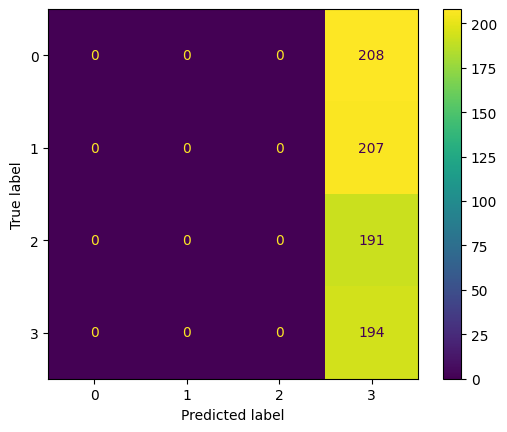

In [105]:
correct=0
SVM_MODEL = pickle.load(open('sift_classifier.pkl', 'rb'))
labels_predicted=[]
for i,test in tqdm(enumerate(X_test)):
      hist=sift(img)
      label=SVM_MODEL.predict([hist])
      labels_predicted.append(label)
      if(label==y_test[i]):
            correct+=1
print(correct/len(X_test)*100)
actual = np.random.binomial(1,.9,size = 1000)
predicted = np.random.binomial(1,.9,size = 1000)
confusion_matrix = metrics.confusion_matrix(y_test, labels_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1,2,3])
cm_display.plot()
plt.show()

[0. 0. 0. ... 0. 0. 0.]
